In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats
import statsmodels.stats.diagnostic as diag
import statsmodels.api as sm
import seaborn as sb
from collections import Counter

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import sklearn.preprocessing
import scipy.cluster.hierarchy as sch
import skfuzzy as fuzz
import pylab
import sklearn.mixture as mixture
import pyclustertend 
import random

In [47]:
# Configuración para mostrar todas las columnas
pd.set_option('display.max_columns', None)
# Configuración para mostrar todas las filas
pd.set_option('display.max_rows', None)

In [48]:
datos=pd.read_csv("movies.csv", encoding="latin1")

## Revisión de datos

El clustering se va a enfocar en las columnas cuantitativas, es por ello vamos a examinar los datos e identificar las que son útiles para hacerlo.

In [49]:
columnas_cuantitativas = datos.select_dtypes(include=['float64', 'int64']).columns.tolist()
columnas_cuantitativas
print(datos[columnas_cuantitativas].var())  # Variables con varianza baja pueden ser eliminadas


id                           6.624452e+10
budget                       1.341514e+15
revenue                      2.237580e+16
runtime                      7.716078e+02
popularity                   4.697170e+04
voteAvg                      9.687953e-01
voteCount                    6.575104e+06
genresAmount                 1.333021e+00
productionCoAmount           6.450267e+00
productionCountriesAmount    9.072706e+00
actorsAmount                 1.383846e+09
dtype: float64


In [50]:
# Tomar solo los datos a comparar
X = datos[['budget', 'revenue', 'runtime', 'popularity', 'voteAvg', 'voteCount']]
X.describe()

,budget,revenue,runtime,popularity,voteAvg,voteCount
count,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.855163e+07,5.673793e+07,100.268100,51.393907,6.483490,1342.381800
std,3.662669e+07,1.495854e+08,27.777829,216.729552,0.984274,2564.196637
min,0.000000e+00,0.000000e+00,0.000000,4.258000,1.300000,1.000000
25%,0.000000e+00,0.000000e+00,90.000000,14.577750,5.900000,120.000000
50%,5.000000e+05,1.631245e+05,100.000000,21.905500,6.500000,415.000000
75%,2.000000e+07,4.479661e+07,113.000000,40.654000,7.200000,1316.000000
max,3.800000e+08,2.847246e+09,750.000000,11474.647000,10.000000,30788.000000


## Tendencia del Agrupamiento

#### Estadístico Hopkins

In [51]:
# Fijar la semilla para obtener resultados reproducibles
random.seed(123)

# Escalar los datos para normalización
X_scale = sklearn.preprocessing.scale(X)

# Calcular la estadística de Hopkins
hopkins_stat = pyclustertend.hopkins(X_scale, len(X_scale))
print(f'Estadística de Hopkins: {hopkins_stat}')

Estadística de Hopkins: 0.016316708610418028


#### VAT

In [ ]:
# Con la escala original
pyclustertend.vat(X)

## ¿Cuántos grupos formamos?
#### Gráfico de codo

In [ ]:
numeroClusters = range(1,15)
wcss = []
for i in numeroClusters:
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(X_scale)
    wcss.append(kmeans.inertia_)

plt.plot(numeroClusters, wcss, marker='o')
plt.xticks(numeroClusters)
plt.xlabel("K clusters")
plt.ylabel("WSS")
plt.title("Gráfico de Codo")
plt.show()

## K-means

In [ ]:
km = KMeans(n_clusters=5).fit(X)
centroides = km.cluster_centers_
especies = km.predict(X)

plt.scatter(X[especies == 0, 0], X[especies == 0, 1],s=100,c='red', label = "Cluster 1")
plt.scatter(X[especies == 1, 0], X[especies == 1, 1],s=100,c='blue', label = "Cluster 2")
plt.scatter(X[especies == 2, 0], X[especies == 2, 1],s=100,c='green', label = "Cluster 3")
plt.scatter(X[especies == 3, 0], X[especies == 3, 1],s=100,c='pink', label = "Cluster 4")
plt.scatter(X[especies == 4, 0], X[especies == 4, 1],s=100,c='purple', label = "Cluster 5")
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1], s=300, c="yellow",marker="*", label="Centroides")
plt.legend()

## Clustering Jerárquico

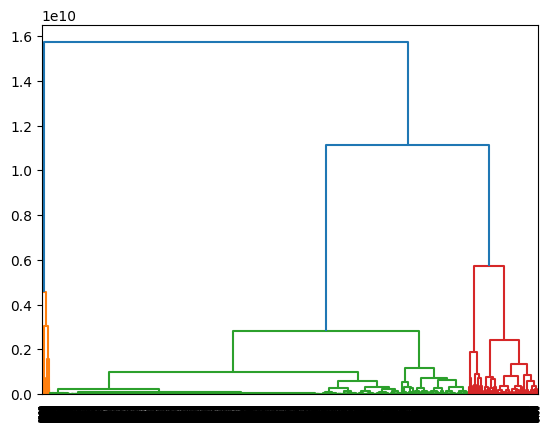

In [45]:
dendograma = sch.dendrogram(sch.linkage(X, method='ward'))

## Análisis de Silhoutte

In [ ]:
n_clusters = 5

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % n_clusters,
    fontsize=14,
    fontweight="bold",
)

plt.show()